Modeling: Point-Source Position
===============================

To fit a lens model to positional constraints of a strong lens, we must perform lens modeling, which uses
a `NonLinearSearch` to fit many different sets of multiple images to the dataset.

In this example script, we fit the multiple-image `Positions` of a strong lens system where:

 - The lens galaxy's total mass distribution is modeled as an `EllipticalIsothermal`.
 - The source `Galaxy` is modeled as a `PointSource`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Load the strong lens dataset `mass_sie__source_point`, which is the dataset we will use to perform lens modeling.

We begin by loading an image of the dataset. Although we are performing point-source modeling and will not use this
data in the model-fit, it is useful to load it for visualization. By passing this dataset to the model-fit at the
end of the script it will be used when visualizing the results. However, the use of an image in this way is entirely
optional, and if it were not included in the model-fit visualization would simple be performed using grids without
the image.

In [2]:
dataset_name = "mass_sie__source_point"
dataset_path = path.join("dataset", "point_source", dataset_name)

image = al.Array2D.from_fits(
    file_path=path.join(dataset_path, "image.fits"), pixel_scales=0.05
)

We now load the positions we will fit using point source modeling. We load them as a `Grid2DIrregular` data 
structure, which groups different sets of positions to a common source. This is used, for example, when there are 
multiple source galaxy's in the source plane. For this simple example, we assume there is just one source and just one 
group.

In [3]:
positions = al.Grid2DIrregular.from_json(
    file_path=path.join(dataset_path, "positions.json")
)

print(positions.in_list)

[(1.1488281249999999, -1.1488281249999996), (1.1089843750000004, 1.1089843750000001), (-1.1089843750000004, -1.1089843750000001), (-1.1488281249999999, 1.148828125)]


We can now plot our positions dataset over the observed image.

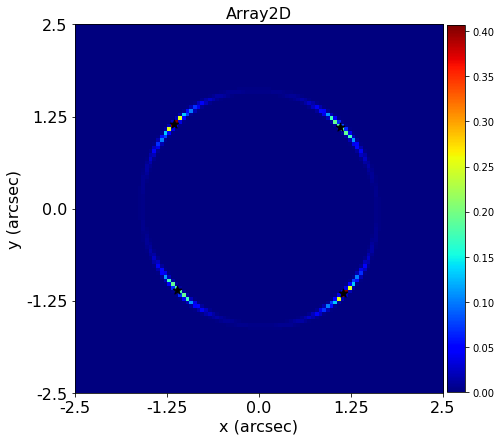

In [4]:
visuals_2d = aplt.Visuals2D(positions=positions)

array_plotter = aplt.Array2DPlotter(array=image, visuals_2d=visuals_2d)
array_plotter.figure()

We can also just plot the positions, omitting the image.

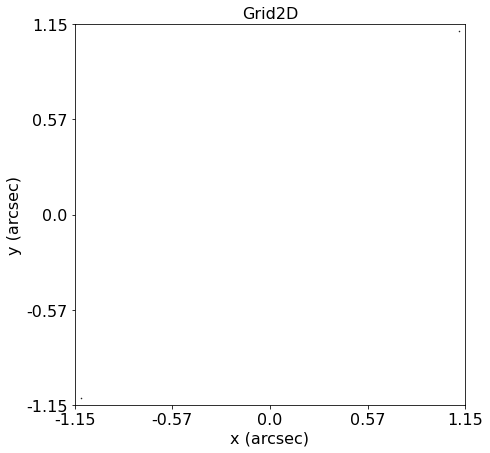

In [5]:
grid_plotter = aplt.Grid2DPlotter(grid=positions)
grid_plotter.figure()

For point-source modeling, we also need the noise of every measured position. This is simply the pixel-scale of our
observed dataset, which in this case is 0.05".

The `position_noise_map` should have the same structure as the `Grid2DIrregular`. In this example, the positions
are a single group of 4 (y,x) coordinates, therefore their noise map should be a single group of 4 floats. We can
make this noise-map by creating a `ValuesIrregular` structure from the `Grid2DIrregular`.

In [6]:
positions_noise_map = positions.values_from_value(value=image.pixel_scale)

print(positions_noise_map)

[0.05 0.05 0.05 0.05]


__Phase__

To perform lens modeling, we create a `PhasePointSource` object, which comprises:

   - The `GalaxyModel`'s used to fit the data.
   - The `SettingsPhase` which customize how the model is fitted to the data.
   - The `NonLinearSearch` used to sample parameter space.

Once we have create the phase, we `run` it by passing it the data and mask.

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens mooel is:

 - An `EllipticalIsothermal` `MassProfile`.for the lens galaxy's mass (5 parameters).
 - A `PointSource` for the source galaxy's emission (2 parameters).

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=7.

NOTE: By default, **PyAutoLens** assumes the image has been reduced such that the lens galaxy centre is at (0.0", 0.0"),
with the priors on the lens `MassProfile` coordinates set accordingly. if for your dataset the lens is not centred at 
(0.0", 0.0"), we recommend you reduce your data so it is (see `autolens_workspace/notebooks/preprocess`).  Alternatively, you 
can manually override the priors (see `autolens_workspace/notebooks/modeling/customize/priors.py`).

In [7]:
lens = al.GalaxyModel(redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = al.GalaxyModel(redshift=1.0, point=al.ps.PointSource)

__Settings__

Next, we specify the `SettingsPhaseImaging`, which describe how the model is fitted to the data in the log likelihood
function. Below, we specify:

 N/A

In [8]:
settings = al.SettingsPhaseImaging()


__PositionsSolver__

For point-source modeling we also need to define our `PositionsSolver`. This object determines the multiple-images of 
a mass model for a point source at location (y,x) in the source plane, by iteratively ray-tracing light rays to the 
source-plane. 

Checkout the script ? for a complete description of this object, we will use the default `PositionSolver` in this 
exampl

In [9]:
grid = al.Grid2D.uniform(
    shape_native=image.shape_native, pixel_scales=image.pixel_scales
)

positions_solver = al.PositionsSolver(grid=grid, pixel_scale_precision=0.02)

__Search__

The lens model is fitted to the data using a `NonLinearSearch`, which we specify below. In this example, we use the
nested sampling algorithm Dynesty (https://dynesty.readthedocs.io/en/latest/), with:

 - 50 live points.

The script `autolens_workspace/notebooks/modeling/customize/non_linear_searches.py` gives a description of the types of
non-linear searches that can be used with **PyAutoLens**. If you do not know what a `NonLinearSearch` is or how it 
operates, I recommend you complete chapters 1 and 2 of the HowToLens lecture series.

The `name` and `path_prefix` below specify the path where results ae stored in the output folder:  

 `/autolens_workspace/output/point_source/mass_sie__source_sersic/phase_mass[sie]_source[bulge]`.

In [10]:
search = af.DynestyStatic(
    path_prefix=path.join("point_source", dataset_name),
    name="phase_mass[sie]_source[point]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings, search and positions_solver to create and run a phase, which fits the data with 
the lens model.

In [11]:
phase = al.PhasePointSource(
    search=search,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    settings=settings,
    positions_solver=positions_solver,
)

We can now begin the fit by passing the positions data and noise_map to the phase, which will use 
the search to fit the model to the data. 

The fit outputs visualization on-the-fly, so checkout the path 
`autolens_workspace/output/examples/phase_mass[sie]_source[point]` to see how your fit is doing!

In [12]:
result = phase.run(positions=positions, positions_noise_map=positions_noise_map)

INFO:root:phase_mass[sie]_source[point] already completed, skipping non-linear search.


The phase above returned a result, which, for example, includes the lens model corresponding to the maximum
log likelihood solution in parameter space.

In [13]:
print(result.max_log_likelihood_instance)

Checkout `autolens_workspace/notebooks/modeling/results.py` for a full description of the result object.